# Identificando Fraudes de Cartão de Crédito (Classificação)

Esse projeto tem como objetivos:
- Analisar um arquivo CSV com 1 milhão de transações de cartão de crédito (normais e fraudulentas) para identificar as **características comuns nas fraudes**;
- Treinar um **modelo de machine learning** para ser capaz de classificar futuras transações como fraudes ou não através de suas características.

# Importando as bibliotecas

In [97]:
# !pip install --upgrade scikit-learn imbalanced-learn
# !pip install graphviz

# Importando os dados

In [99]:
import pandas as pd

uri = "https://github.com/alura-cursos/youtube-alura/raw/refs/heads/main/fraud_dataset.csv"
dados = pd.read_csv(uri)
dados

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


## Significado das colunas

- **distance_from_home**: distância do local da transação para a casa do cliente, em km;

- **distance_from_last_transaction**: distância do local da transação para o local da última transação, em km;

- **ratio_to_median_purchase_price**: proporção ao preço médio de compra (vai de 0 ao infinito). Ex: se é 1.0, significa que o valor da transação é igual ao preço médio de compra (100%). Se é 0.5, significa que o valor da transação é igual a 50% do preço médio de compra;

- **repeat_retailer**: se o lojista é recorrente (1-sim, 0-não);

- **used_chip**: se foi usado chip (1-sim, 0-não);

- **used_pin_number**: se foi usada a senha do cartão de crédito (1-sim, 0-não);

- **online_order**: se foi compra online (1-sim, 0-não);

- **fraud**: se a transação é uma fraude (1-sim, 0-não);

## Buscando valores nulos

In [102]:
dados.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

Não existem valores nulos.

# Análise exploratória

## A variável target (y): fraud

C:\Users\marco\AppData\Local\Temp\ipykernel_5876\2320098963.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(["Não", "Sim"]);


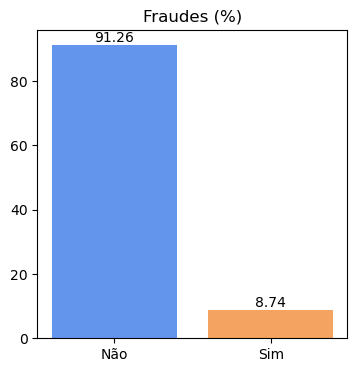

In [106]:
import matplotlib.pyplot as plt

contagem = (dados.fraud.value_counts(normalize=True) * 100).round(2)

azul = "cornflowerblue"
laranja = "sandybrown"
cores = [azul, laranja]

plt.figure(figsize=(4, 4))
bars = plt.bar(contagem.index.astype(str), contagem, color=cores)
plt.bar_label(bars)
plt.title("Fraudes (%)")
plt.gca().set_xticklabels(["Não", "Sim"]);

Existem muito mais casos de "não fraude" do que de fraude (era esperado), pois apenas cerca de 9% das transações são fraudulentas. Mas isso pode variar de acordo com o cenário, como cenário de comprar online X compras presenciais, compras com chip X compras sem chip, etc. Veremos mais abaixo.

Mas de qualquer forma, teremos que lidar com esse **desequilíbrio de classes** para treinarmos nosso algoritmo de machine learning. Mais abaixo usaremos a técnica SMOTE para fazer Oversampling, para assim treinarmos adequadamente nosso algoritmo, para que fique preciso em identificar fraudes.

## Variáveis contínuas

### Boxplot

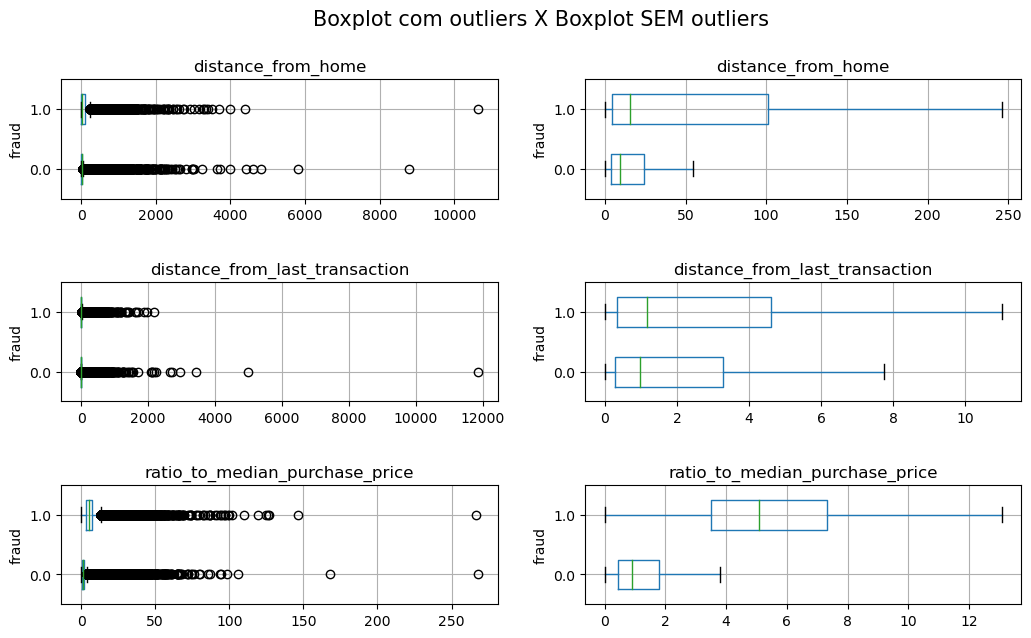

In [110]:
variaveis_continuas = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price",
    ]

fig, axes = plt.subplots(3, 2, figsize=(12, 7))
fig.subplots_adjust(hspace=0.7)

dados.boxplot(variaveis_continuas, by="fraud", vert=False, widths=0.5,
              ax=axes[::, 0], sharex=False, sharey=False)

dados.boxplot(variaveis_continuas, by="fraud", vert=False, widths=0.5,
              ax=axes[::,1], sharex=False, sharey=False, showfliers=False);

fig.suptitle("Boxplot com outliers X Boxplot SEM outliers", size=15, y=1);

As variáveis acima alcançam **valores maiores em casos de fraude**, principalmente a proporção ao preço médio de compra, o que faz sentido já que normalmente fraudadores fazem compras de alto valor.
<br>Podemos concluir que:
- Se numa transação as variáveis acima possuem valores mais baixos, são mais baixas as chances de se tratar de uma fraude. Caso contrário, se possuem valores muito altos, são mais altas as chances de fraude.

Abaixo uma análise descritiva, com média, mediana, quartis, etc:

### Análise descritiva

In [113]:
dados.groupby("fraud")[variaveis_continuas].describe().round(2).T

fraud                                       0.0       1.0
distance_from_home             count  912597.00  87403.00
                               mean       22.83     66.26
                               std        52.83    134.39
                               min         0.00      0.03
                               25%         3.83      4.59
                               50%         9.67     15.45
                               75%        24.16    101.11
                               max      8777.14  10632.72
distance_from_last_transaction count  912597.00  87403.00
                               mean        4.30     12.71
                               std        22.47     48.00
                               min         0.00      0.00
                               25%         0.29      0.33
                               50%         0.99      1.16
                               75%         3.27      4.60
                               max     11851.10   2160.50
ratio_to_median_purchase_price count  912597.00  87403.00
                               mean        1.42      6.01
                               std         1.95      5.56
                               min         0.00      0.01
                               25%         0.45      3.50
                               50%         0.91      5.07
                               75%         1.79      7.33
                               max       267.80    266.69

As **médias** mostram o que vimos acima. Porém o problema de olhar só as médias é que elas costumam ser muito afetadas pelos outliers. Por isso a importância de olharmos também os **quartis** e os **boxplots**.

## Variáveis categóricas

### Comportamento das variáveis categóricas em cenários de Fraude x Não fraude

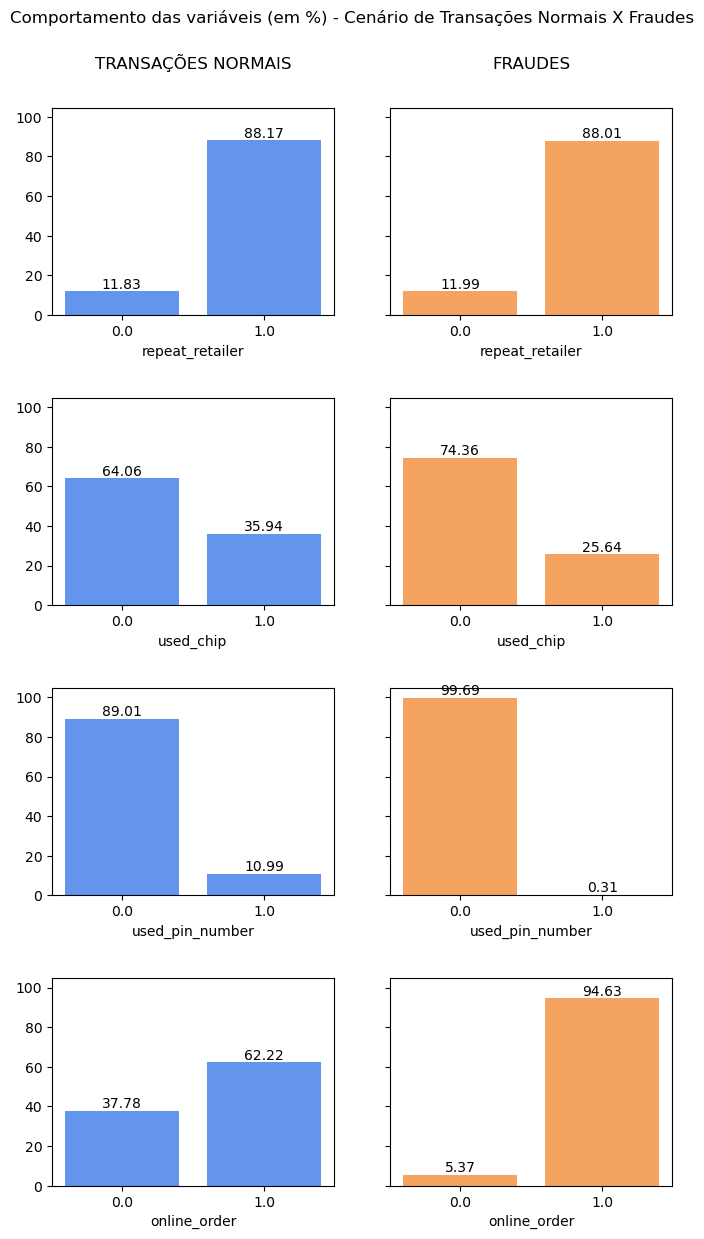

In [117]:
# # NO GOOGLE COLAB: AUMENTANDO A JANELA DE OUTPUT PARA NÃO PRECISAR
# # USAR A BARRA DE ROLAGEM
# from IPython.display import Javascript
# display(Javascript(
#     "google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})"))

variaveis_categoricas = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order",
    ]

fig, axes = plt.subplots(len(variaveis_categoricas), 2, figsize=(8, 14),
                         sharey=True)
fig.subplots_adjust(hspace=0.4)

for fraud, cor in zip([0, 1], cores):
    for i, variavel in enumerate(variaveis_categoricas):
        ax = axes[i][fraud]
        contagem = dados[dados.fraud == fraud][variavel].value_counts(
            normalize=True).sort_index()
        contagem = (contagem * 100).round(2)
        bars = ax.bar(contagem.index.astype(str), contagem, color=cor)
        ax.bar_label(bars)
        ax.set_xlabel(variavel)

fig.suptitle("Comportamento das variáveis (em %) - "
             "Cenário de Transações Normais X Fraudes", y=0.95)
axes[0][0].set_title("TRANSAÇÕES NORMAIS", y=1.15)
axes[0][1].set_title("FRAUDES", y=1.15);

Em comparação às transações normais, as fraudes:
- Quase nunca usam a senha do cartão (pin number): apenas 0,31%;
- São quase todas em compras online (aprox. 95%).

<br>Agora vejamos qual é o percentual de fraudes por variável:

### % de fraudes em cada cenário isolado

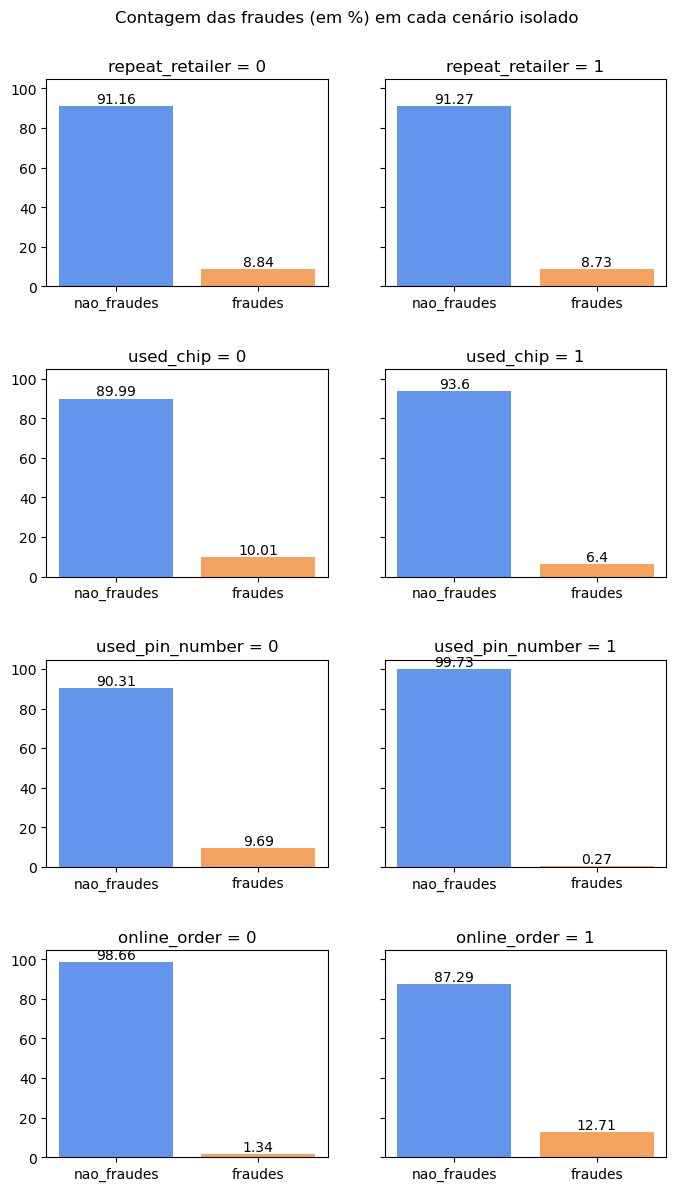

In [120]:
# # NO GOOGLE COLAB: AUMENTANDO A JANELA DE OUTPUT PARA NÃO PRECISAR
# # USAR A BARRA DE ROLAGEM
# display(Javascript(
#     "google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})"))

fig, axes = plt.subplots(len(variaveis_categoricas), 2, figsize=(8, 14),
                         sharey=True)
plt.subplots_adjust(hspace=0.4)

for i, variavel in enumerate(variaveis_categoricas):
    for b in [0, 1]:
        ax = axes[i][b]
        contagem = dados[dados[variavel] == b].fraud.replace(
            [0, 1], ["nao_fraudes", "fraudes"]).value_counts(
            normalize=True).sort_index(ascending=False)
        contagem = (contagem * 100).round(2)
        bars = ax.bar(contagem.index.astype(str), contagem, color=cores)
        ax.bar_label(bars)
        ax.set_title(f"{variavel} = {b}")

plt.suptitle("Contagem das fraudes (em %) em cada cenário isolado", y=0.93);

- Usar a **senha parece ser um ótimo fator de segurança**, pois das transações com senha, apenas 0,27% são fraudes, enquanto que das transações sem senha, 9,69% são fraudes, um aumento de 3.470,00%!!!
- Em seguida temos se a **compra foi online ou não**, onde o percentual de fraudes vai de 1,34% para 12,71%, um aumento de 847%!

<br>Segue a diferença de cada variável:

In [122]:
print("Percentual (%) de fraudes por variável (dif = diferença em %)")
lista = [
    pd.crosstab(dados[variavel], dados.fraud, normalize="index")[1]
    for variavel in variaveis_categoricas
    ]
probabilidades = pd.concat(lista, axis=1)
probabilidades.columns = variaveis_categoricas
probabilidades.loc["dif"] = probabilidades.apply(
    lambda x: max(x[0], x[1]) / min(x[0], x[1]) - 1)
probabilidades = (probabilidades * 100).round(2)
probabilidades

Percentual (%) de fraudes por variável (dif = diferença em %)


,repeat_retailer,used_chip,used_pin_number,online_order
0.0,8.84,10.01,9.69,1.34
1.0,8.73,6.40,0.27,12.71
dif,1.36,56.44,3470.17,846.90


### % de fraudes em cada cenário combinado

In [124]:
print("===== Contagem de fraudes em cada cenário "
      "(combinação das variáveis) =====")
colunas_ordenadas = probabilidades.loc["dif"].sort_values(
    ascending=False).index
contagens = [
    dados[dados.fraud == i][colunas_ordenadas].value_counts(sort=False)
    for i in dados.fraud.unique()
    ]
cenarios = pd.concat(contagens, axis=1).fillna(0)
cenarios.columns = ["nao_fraudes", "fraudes"]
cenarios["percentual_fraudes"] = (
    cenarios.iloc[:,1]
    / (cenarios.iloc[:,0] + cenarios.iloc[:,1])
    * 100
    ).round(2)
cenarios

===== Contagem de fraudes em cada cenário (combinação das variáveis) =====


nao_fraudes  fraudes  \
used_pin_number online_order used_chip repeat_retailer                         
0.0             0.0          0.0       0.0                    21543   2451.0   
                                       1.0                   178700   1430.0   
                             1.0       0.0                    13190     16.0   
                                       1.0                    96125    794.0   
                1.0          0.0       0.0                    39891   5180.0   
                                       1.0                   279183  55668.0   
                             1.0       0.0                    21417   2817.0   
                                       1.0                   162213  18774.0   
1.0             0.0          0.0       0.0                     2650      0.0   
                                       1.0                    20178      0.0   
                             1.0       0.0                     1465      0.0   
                                       1.0                    10905      1.0   
                1.0          0.0       0.0                     5024      8.0   
                                       1.0                    37439    256.0   
                             1.0       0.0                     2806      6.0   
                                       1.0                    19868      2.0   

                                                        percentual_fraudes  
used_pin_number online_order used_chip repeat_retailer                      
0.0             0.0          0.0       0.0                           10.22  
                                       1.0                            0.79  
                             1.0       0.0                            0.12  
                                       1.0                            0.82  
                1.0          0.0       0.0                           11.49  
                                       1.0                           16.62  
                             1.0       0.0                           11.62  
                                       1.0                           10.37  
1.0             0.0          0.0       0.0                            0.00  
                                       1.0                            0.00  
                             1.0       0.0                            0.00  
                                       1.0                            0.01  
                1.0          0.0       0.0                            0.16  
                                       1.0                            0.68  
                             1.0       0.0                            0.21  
                                       1.0                            0.01

De acordo com os cenários acima, vemos que:

<br>Se uma transação tem:
- used_pin_number = 0
- online_order = 1
- used_chip = 0
- repeat_retailer = 1
- **= chance de ser fraude: 16,62%**

<br>Se uma transação tem:
- used_pin_number = 1
- online_order = 0
- used_chip = 1
- repeat_retailer = 0
- **= chance de ser fraude: 0%**

<br>Isso é só uma **análise superficial**, para termos ideia que quais variáveis categóricas representam mais chances da transação ser fraudulenta. Abaixo treinaremos nosso modelo de machine learning para nos dizer com precisão se uma transação é uma fraude ou não, considerando tanto essas variáveis categóricas como as contínuas.

# Treinando o modelo de machine learning

## Técnica holdout: Separação dos dados em treino e teste

In [128]:
from sklearn.model_selection import train_test_split
SEED = 7

X = dados.drop(columns="fraud")
y = dados.fraud
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=SEED)

## Overfitting da classe minoritária (das fraudes)

Aumentar os exemplos de fraudes, igualando à quantidade de não-fraudes, para o modelo ficar bom em identificar fraudes

In [130]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Padronizando as variáveis explicativas

Para o modelo não ficar enviesado para a variável com escala mais alta. Padronizaremos todas as variáveis explicativas com **StandardScaler**:

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## LogisticRegression

Como queremos apenas saber se uma transação é ou não fraude (0 ou 1), começaremos usando o modelo de Regressão Logística

In [134]:
from sklearn.linear_model import LogisticRegression

modelo_logistico = LogisticRegression(random_state=SEED)
modelo_logistico.fit(X_train_res_scaled, y_train_res)
y_pred = modelo_logistico.predict(X_test_scaled)

### Resultados

In [136]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96    182519
         1.0       0.58      0.95      0.72     17481

    accuracy                           0.94    200000
   macro avg       0.79      0.94      0.84    200000
weighted avg       0.96      0.94      0.94    200000



Refinando os resultados:

In [138]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def resultados(y_test, y_pred, matriz=False):
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Sensibilidade: {recall_score(y_test, y_pred):.2%}")
    print(f"Precisão: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1 score: {f1_score(y_test, y_pred):.2%}")
    print(f"Curva ROC: {roc_auc_score(y_test, y_pred):.2%}")
    if matriz:
        print("\n===== MATRIZ DE CONFUSÃO =====")
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm).plot()

Acurácia: 93.51%
Sensibilidade: 95.11%
Precisão: 57.82%
F1 score: 71.92%
Curva ROC: 94.23%

===== MATRIZ DE CONFUSÃO =====


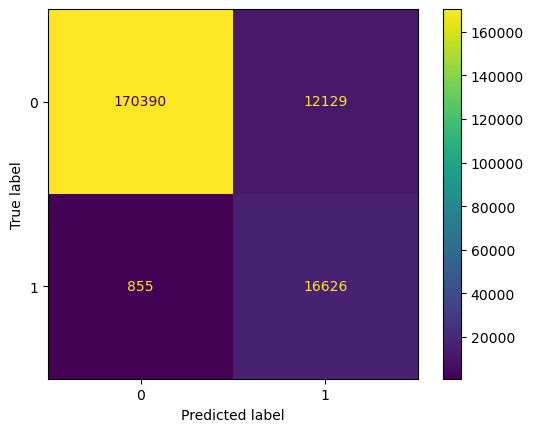

In [139]:
resultados(y_test, y_pred, matriz=True)

Olhar só a **Acurácia** (% acertos em geral) **não é o suficiente** pois queremos identificar o máximo de fraudes possíveis, mas também sem errar muito sobre as transações normais. Por isso estamos considerando também as seguintes medidas:
- **Sensibilidade (Revocação)**: A MAIS IMPORTANTE, é o % de fraudes detectadas;
- **Precisão**: % fraudes alegadas pelo modelo que realmente são fraudes;
- **F1 Score**: média harmônica entre Sensibilidade e Precisão;
- **Curva ROC**: basicamente é o quanto o modelo acerta as fraudes sem errar as não-fraudes.

A **Matriz de Confusão** é apenas uma análise visual das informações acima, como quantas fraudes são identificadas e quantas passam despercebidas (Sensibilidade), quantas fraudes declaradas realmente as são (Precisão), etc.

### Resultados sem o Overfitting

Se não tivéssemos feito o Overfitting, a Sensibilidade ficaria bem pior:

Acurácia: 95.89%
Sensibilidade: 60.31%
Precisão: 89.14%
F1 score: 71.94%
Curva ROC: 79.80%

===== MATRIZ DE CONFUSÃO =====


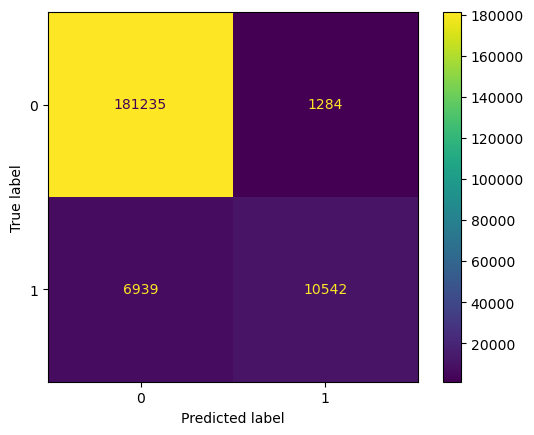

In [142]:
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train)
X_test_scaled2 = scaler2.transform(X_test)

modelo_sem_overfitting = LogisticRegression(random_state=SEED)
modelo_sem_overfitting.fit(X_train_scaled2, y_train)
y_pred_sem_overfitting = modelo_sem_overfitting.predict(X_test_scaled2)
resultados(y_test, y_pred_sem_overfitting, matriz=True)

## DummyClassifiers (para comparação)

Modelos bobos, apenas para compararmos se nosso modelo não está muito melhor. Se os resultados forem semelhantes, isso é péssimo.

#### Prevendo tudo como 0 (não-fraude)

In [145]:
from sklearn.dummy import DummyClassifier

# A estratégia "prior" é a padrão (nesse caso, vai prever tudo como 0 - não-fraude)
dummy_prior = DummyClassifier()
dummy_prior.fit(X_train_res_scaled, y_train_res)
y_pred = dummy_prior.predict(X_test_scaled)
resultados(y_test, y_pred)

Acurácia: 91.26%
Sensibilidade: 0.00%
Precisão: 0.00%
F1 score: 0.00%
Curva ROC: 50.00%


A Acurácia não parece tão ruim, porém a Sensibilidade ficou em 0%. Ou seja, todas as fraudes passaram despercebidas! Por isso a importância de olharmos as outras métricas.

#### Prevendo tudo como 1 (fraude)

In [148]:
dummy_constant = DummyClassifier(strategy="constant", constant=1)
dummy_constant.fit(X_train_res_scaled, y_train_res)
y_pred = dummy_constant.predict(X_test_scaled)
resultados(y_test, y_pred)

Acurácia: 8.74%
Sensibilidade: 100.00%
Precisão: 8.74%
F1 score: 16.08%
Curva ROC: 50.00%


Aqui a Sensibilidade ficou em 100%, ou seja, identificou todas as fraudes! Parece ótimo, mas a precisão ficou horrível, já que esse dummy errou o diagnóstico de todas as não-fraudes dizendo que são todas fraudes. Isso é péssimo.

#### Prevendo de forma estratificada (mesma proporção de fraudes vista no treino)

In [151]:
dummy_stratified = DummyClassifier(strategy="stratified", random_state=SEED)
dummy_stratified.fit(X_train_res_scaled, y_train_res)
y_pred = dummy_stratified.predict(X_test_scaled)
resultados(y_test, y_pred)

Acurácia: 50.09%
Sensibilidade: 49.99%
Precisão: 8.76%
F1 score: 14.90%
Curva ROC: 50.05%


Esse se saiu menos pior. Nosso modelo de Regressão Logística está muito melhor. Segue novamente:

Acurácia: 93.51%
Sensibilidade: 95.11%
Precisão: 57.82%
F1 score: 71.92%
Curva ROC: 94.23%

===== MATRIZ DE CONFUSÃO =====


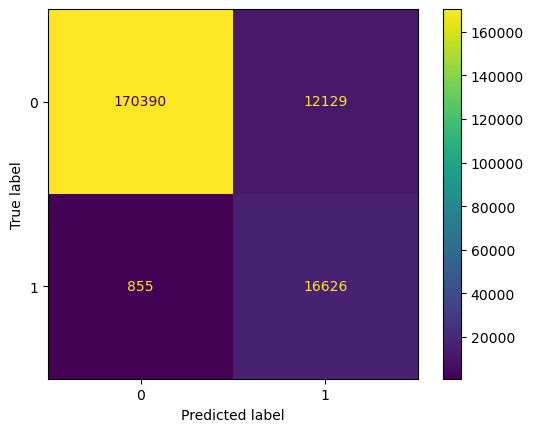

In [153]:
y_pred = modelo_logistico.predict(X_test_scaled)
resultados(y_test, y_pred, matriz=True)

Vejamos se conseguimos melhores resultados com outros modelos:

## DecisionTree

Acurácia: 99.38%
Sensibilidade: 99.35%
Precisão: 93.92%
F1 score: 96.56%
Curva ROC: 99.37%

===== MATRIZ DE CONFUSÃO =====


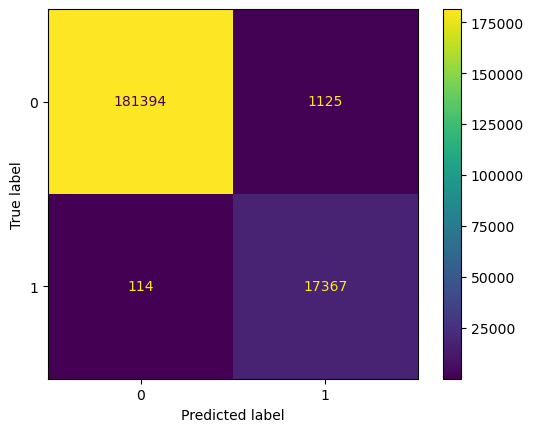

In [156]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=SEED)
tree.fit(X_train_res_scaled, y_train_res)
y_pred = tree.predict(X_test_scaled)
resultados(y_test, y_pred, matriz=True)

A árvore de decisão se saiu muito melhor, entregando quase **87% menos falsos negativos**! (fraudes não detectadas caíram de 855 para 114 (-741))

### Visualizando a árvore

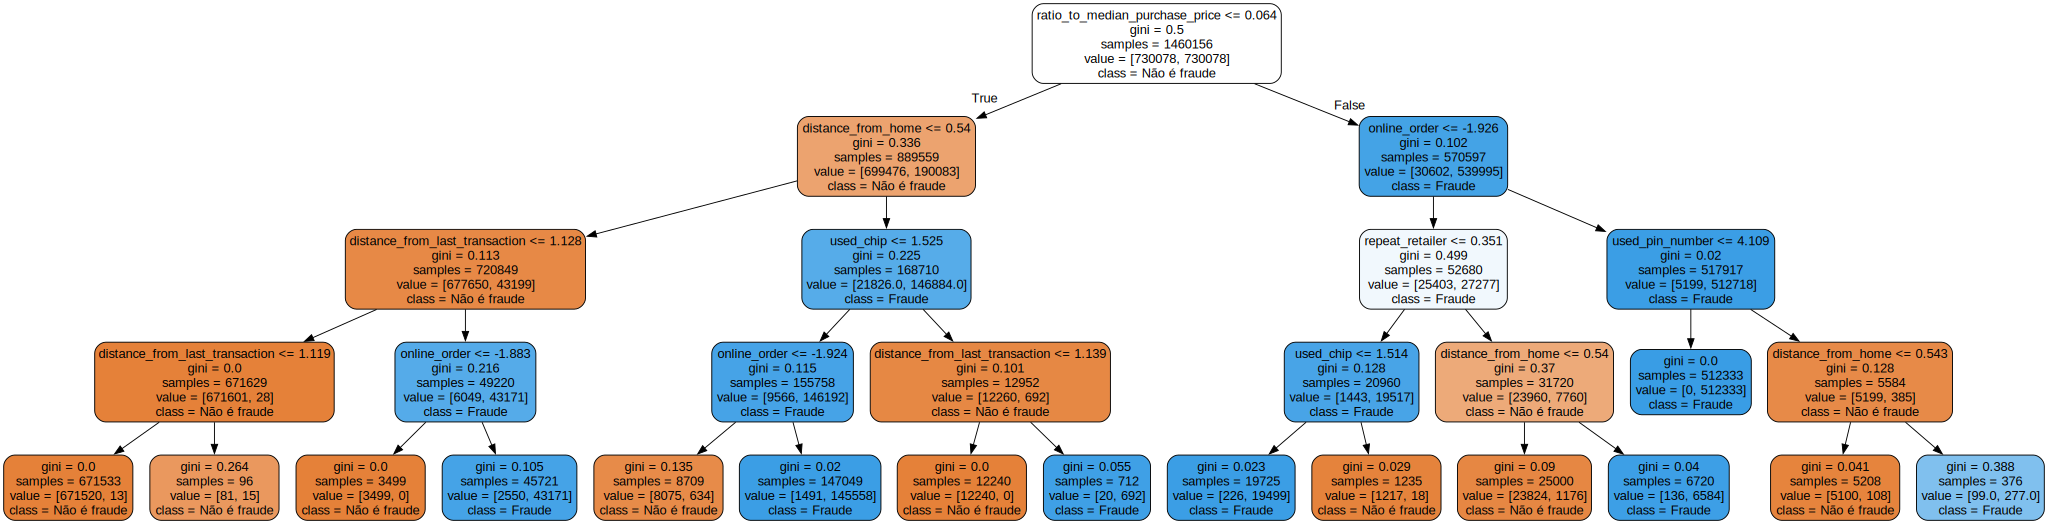

In [192]:
from sklearn.tree import export_graphviz
import graphviz

dot = export_graphviz(
    tree, feature_names=X.columns, class_names=["Não é fraude", "Fraude"],
    filled=True, rounded=True)
graphviz.Source(dot)

A árvore ficou grande. Caso quiséssemos **diminuir**, poderíamos mexer na:
- profundidade (**max_depth**);
- quantidade mínima de amostras para criar uma folha (**min_samples_leaf**)
- quantidade mínima de amostras para dividir um nó (**min_samples_split**)

Porém, deve-se mexer com cuidado para não perdermos eficiência.

<br>Vejamos se conseguimos um modelo ainda melhor:

## RandomForest

"Floresta de árvores", usa várias DecisionTrees (por padrão 100) para chegar a um resultado final.

Esse modelo costuma ser mais robusto, mais preciso e evita o overfitting, porém é bem mais lento.

Acurácia: 99.85%
Sensibilidade: 99.81%
Precisão: 98.55%
F1 score: 99.17%
Curva ROC: 99.83%

===== MATRIZ DE CONFUSÃO =====


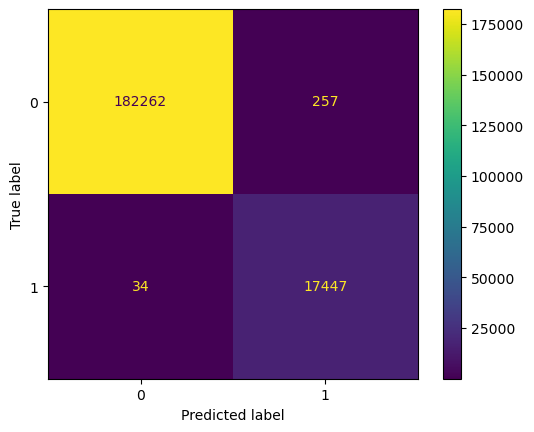

In [163]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=4, random_state=SEED, n_jobs=-1)
# n_jobs=-1 para paralelizar e agilizar o processo, usando todos os
# núcleos disponíveis. Usar com cautela.
rf.fit(X_train_res_scaled, y_train_res)
y_pred = rf.predict(X_test_scaled)
resultados(y_test, y_pred, matriz=True)

Apesar da lentidão, conseguiu se sair ainda melhor, entregando **70% menos falsos negativos** que a DecisionTree (fraudes não detectadas caíram de 114 para 34 (-80)).

Vejamos se conseguimos resultados ainda melhores refinando os hiperparâmetros:

### RandomSearchCV

- Ajuda a encontrar os **melhores hiperparâmetros** para otimizarmos nosso modelo;
- Porém normalmente **demora muito**, ainda mais quando há muitos hiperparâmetros para testar. Por isso é necessário escolhermos o número de interações/combinações de hiperparâmetros para testar aleatoriamente. Para otimizar o modelo ao máximo possível, o ideal é testar todas as combinações de hiperparâmetros. Mas vai depender do custo computacional e se há tempo disponível para esperar;
- É uma versão do **GridSearchCV**, que testa todos os hiperparâmetros fornecidos, porém **demora MUITO**, demora até horas;
- Além disso, por padrão é feita uma **Validação Cruzada** de 5-folds, que divide os dados em treino/teste de 5 formas diferentes, testando cada cenário (dobra). Assim evita o enviesamento de uma única divisão ruim que ocasionalmente possamos fazer no holdout;
- Usaremos **Pipeline** para que o Overfitting e a Padronização com StandardScaler sejam aplicados somente nos dados de teste de cada cenário (dobra) da validação cruzada.

In [166]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
# Pipeline da imblearn permite inserir o SMOTE, diferente da sklearn

pipeline = Pipeline([
    ("smote", SMOTE()),
    ("scaler", StandardScaler()),
    ("modelo", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
    ])
parametros = {
    "modelo__criterion": ["gini", "entropy", "log_loss"],
    "modelo__max_depth": range(4, 11),
    "modelo__bootstrap": [True, False],
    }
gs = RandomizedSearchCV(
    pipeline,
    parametros,
    n_iter=2,
    scoring=["recall", "precision", "f1"],
    refit="f1",
    n_jobs=-1,
    random_state=SEED,
    )
gs.fit(X, y);

In [200]:
pd.DataFrame(gs.cv_results_).sort_values(
    ["rank_test_f1", "rank_test_recall", "rank_test_precision"]
    )[[
        "mean_test_recall",
        "mean_test_precision",
        "mean_test_f1",
        "rank_test_recall",
        "rank_test_precision",
        "rank_test_f1",
        "param_modelo__criterion",
        "param_modelo__max_depth",
        "param_modelo__bootstrap",
    ]].reset_index(drop=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelo__max_depth,param_modelo__criterion,param_modelo__bootstrap,params,split0_test_recall,split1_test_recall,...,std_test_precision,rank_test_precision,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,1044.608550,6.723134,10.580308,0.438247,8,log_loss,True,"{'modelo__max_depth': 8, 'modelo__criterion': ...",0.999771,0.999943,...,0.000000,1,0.999886,0.999971,0.999971,0.999828,0.999943,0.999920,0.000055,1
1,1088.705356,239.855637,10.611574,5.637631,10,entropy,False,"{'modelo__max_depth': 10, 'modelo__criterion':...",0.999771,0.999943,...,0.000046,2,0.999886,0.999971,0.999943,0.999886,0.999886,0.999914,0.000036,2


In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
# Pipeline da imblearn permite inserir o SMOTE, diferente da sklearn

pipeline = Pipeline([
    ("smote", SMOTE()),
    ("scaler", StandardScaler()),
    ("classifier", DecisionTreeClassifier(random_state=SEED)),
    ])
parametros = {
    "classifier__criterion": ["gini", "entropy", "log_loss"],
    "classifier__max_depth": range(3, 11),
    }
gs = GridSearchCV(
    pipeline,
    parametros,
    scoring=["recall", "precision", "f1"],
    refit="f1",
    n_jobs=-1,
    )
    # n_jobs=-1 permite a paralelização, tornando mais rápido
gs.fit(X, y);

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values(
    ["rank_test_f1", "rank_test_recall", "rank_test_precision"]
    )[[
        "mean_test_recall",
        "mean_test_precision",
        "mean_test_f1",
        "rank_test_recall",
        "rank_test_precision",
        "rank_test_f1",
        "param_modelo__criterion",
        "param_modelo__max_depth",
    ]].reset_index(drop=True)

,mean_test_recall,mean_test_precision,mean_test_f1,rank_test_recall,rank_test_precision,rank_test_f1,param_classifier__criterion,param_classifier__max_depth
0,0.999886,0.999886,0.999886,2,2,1,log_loss,7
1,0.999874,0.999886,0.999880,7,1,2,gini,7
2,0.999886,0.999851,0.999868,2,3,3,log_loss,10
3,0.999897,0.999817,0.999857,1,5,4,entropy,9
4,0.999874,0.999828,0.999851,7,4,5,log_loss,8
5,0.999874,0.999817,0.999846,5,6,6,gini,8
6,0.999886,0.999806,0.999846,2,9,7,entropy,10
7,0.999874,0.999817,0.999846,6,8,8,entropy,8
8,0.999874,0.999817,0.999846,7,7,9,gini,10
9,0.999863,0.999794,0.999828,10,10,10,entropy,7


Há uma **diferença muito pequena** entre os 15 primeiros modelos (linha 0 a 14), onde o hiperparâmetro max_depth é a partir de 6, fazendo os modelos terem desempenho alto, quase iguais entre si.
<br>A princípio, poderíamos usar o modelo mais simples deles. Porém, como estamos tratando de fraude bancária, **é muito importante identificarmos o máximo possível**. Cada fraude não identificada é um cliente que está sendo roubado, e uma grande dor de cabeça para a instituição, que pode ser processada, sair noticiário e perder reputação.
<br>Então, apesar de 99,9897% e 99,9886% parecerem iguais (com uma diferença de apenas 0,0011%), se considerarmos um cenário de 100 milhões de transações por dia, é uma diferença de **1.100 fraudes não identificadas por dia**. Só para termos um comparativo, as transações Pix no Brasil chegaram a bater recorde de 224 milhões de transações por dia em 2024 (fonte: [Agência Brasil](https://agenciabrasil.ebc.com.br/economia/noticia/2024-07/pix-bate-recorde-e-supera-224-milhoes-de-transacoes-em-um-dia)).
<br>Logo, é importante sempre contextualizarmos esses números percentuais para o cenário do negócio que estamos trabalhando.

Hiperparâmetros do melhor modelo

In [ ]:
gs.best_params_

{'classifier__criterion': 'log_loss', 'classifier__max_depth': 7}

Encontrado o melhor modelo, faremos a **Validação Cruzada Aninhada** para obtermos resultados mais realistas, que não sejam tão otimistas

In [ ]:
from sklearn.model_selection import cross_val_score

final_scores = cross_val_score(gs, X, y, cv=5, scoring="f1", n_jobs=-1)

In [ ]:
media = final_scores.mean()
desvio = final_scores.std()
min, max = media - 2*desvio, media + 2*desvio
print(f'''SCORE F1 DO MELHOR MODELO
Média: {media:.6%}
Intervalo de confiança: [{min:.6%}, {max:.6%}]''')

SCORE FINAL F1 DO MELHOR MODELO
Média: 0.999868
Intervalo: [0.999769, 0.999968]


# Finalizando e salvando o modelo

Com o modelo final determinado, vamos treiná-lo com TODOS os dados e salvá-lo para reutilização ou implantação posterior

In [ ]:
import joblib

sm = SMOTE(random_state=SEED)
X_resampled, y_resampled = sm.fit_resample(X, y)

scaler = StandardScaler()
scaler.fit(X_resampled)
X_scaled = scaler.transform(X_resampled)

modelo = RandomForestClassifier(random_state=SEED, n_jobs=-1)
modelo.fit(X_scaled, y_resampled)
modelo_e_scaler = (modelo, scaler)
joblib.dump(modelo_e_scaler, 'modelo_e_scaler.pkl')


O modelo salvo pode ser carregado mais tarde para fazer previsões em novos dados, sem a necessidade de treiná-lo novamente. Esse seria o código:

In [ ]:
import joblib

modelo, scaler = joblib.load('modelo_e_scaler.pkl')

X_novos_dados = X  # Novos dados recebidos
X_novos_dados_scaled = scaler.trasform(X_novos_dados)
y_novas_previsoes = modelo.predict(X_novos_dados_scaled)
